# Implementing the impact of the radial integral constraint on the (pseudo-) power spectrum computation

Let's try to include radial integral constraints.

In [1]:
from pathlib import Path
from functools import partial
#import os
#os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.' # NOTE: jax preallocates GPU (default 75%)

import numpy as np
import jax
from jax import numpy as jnp
from jax import random

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 4)

from jaxpower import (ParticleField, compute_mesh_power, compute_mean_mesh_power,
compute_normalization, generate_anisotropic_gaussian_mesh, utils)

plots_dir = Path('_plots')

In [2]:
# To highlight the effect of the window convolution,
# we generate a power spectrum with high frequency BAO

from cosmoprimo.fiducial import DESI
cosmo = DESI(engine='eisenstein_hu_nowiggle')
pk = cosmo.get_fourier().pk_interpolator().to_1d(z=1.)
kin = jnp.geomspace(1e-3, 1e1, 200)
pkin = pk(kin) * (1. + 0.2 * np.sin(kin / 0.006))
ells = (0, 2, 4)

f, b = 0.8, 1.5
pkb = b**2 * pkin
beta = f / b
poles = [(1. + 2. / 3. * beta + 1. / 5. * beta ** 2) * pkb,
         0.9 * (4. / 3. * beta + 4. / 7. * beta ** 2) * pkb,
          8. / 35 * beta ** 2 * pkb]
poles = jnp.array(poles)

boxsize, meshsize = 2000., 128
edges = np.arange(0., np.pi / (boxsize / meshsize), 0.005)

def make_callable(poles):
    toret = {}
    def get_fun(ill):
        return lambda k: jnp.interp(k, kin, poles[ill], left=0., right=0.)
    for ill, ell in enumerate(ells):
        toret[ell] = get_fun(ill)
    return toret

def gaussian_survey(boxsize=boxsize, meshsize=meshsize, size=int(1e8), seed=random.key(42), scale=0.2, paint=False):
    # Generate Gaussian-distributed positions
    boxcenter = np.array((boxsize * 0.55, 0., 0.))
    positions = scale * random.normal(seed, shape=(size, 3))
    bscale = 2. * scale  # cut at 2 sigmas
    mask = jnp.all((positions > -bscale) & (positions < bscale), axis=-1)
    positions = positions * boxsize + boxcenter
    toret = ParticleField(positions, weights=1. * mask, boxcenter=boxcenter, boxsize=boxsize, meshsize=meshsize)
    if paint: toret = toret.paint(resampler='cic', interlacing=1, compensate=False)
    return toret

def apply_selection(mesh, selection, ic=None):
    # Selection function
    mesh = mesh * selection
    if ic == 'radial':
        dmin = np.min(selection.boxcenter - selection.boxsize / 2.)
        dmax = (1. + 1e-9) * np.sqrt(np.sum((selection.boxcenter + selection.boxsize / 2.)**2))
        edges = jnp.linspace(dmin, dmax, 1000)
        rnorm = jnp.sqrt(sum(xx**2 for xx in selection.coords(sparse=True))).ravel()
        ibin = jnp.digitize(rnorm, edges, right=False)
        bw = jnp.bincount(ibin, weights=mesh.ravel(), length=len(edges) + 1)
        b = jnp.bincount(ibin, weights=selection.ravel(), length=len(edges) + 1)
        # Integral constraint
        bw = bw / jnp.where(b == 0., 1., b)  # (integral of W * delta) / (integral of W)
        mesh -= bw[ibin].reshape(selection.shape) * selection
    return mesh

def mock_survey(poles, selection, unitary_amplitude=True, los='local', ic=None, seed=random.key(42)):
    # Generate Gaussian field
    mesh = generate_anisotropic_gaussian_mesh(make_callable(poles), unitary_amplitude=unitary_amplitude,
                                              boxsize=selection.boxsize, meshsize=selection.meshsize, boxcenter=selection.boxcenter,
                                              los=los, seed=seed)

    # Multiply Gaussian field with survey selection function, then compute power spectrum
    norm = compute_normalization(selection, selection)
    mesh = apply_selection(mesh, selection, ic=ic)
    return compute_mesh_power(mesh, edges=edges, ells=ells, los={'local': 'firstpoint'}.get(los, los)).clone(norm=norm)


/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20241221-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


In [3]:
gaussian_survey = jax.jit(gaussian_survey, static_argnames=['size', 'paint'])
selection = gaussian_survey(paint=True)

get_pk = lambda pkin, **kwargs: mock_survey(pkin, selection, unitary_amplitude=False, **kwargs)
get_pk = jax.jit(get_pk, static_argnames=['ic'])

from tqdm import trange
pks, pks_ic = [], []
npk = 1000
with trange(npk) as t:
    for imock in t:
        seed = random.key(2 * imock + 1)
        pks.append(get_pk(poles, seed=seed, ic=None))
        pks_ic.append(get_pk(poles, seed=seed, ic='radial'))


100%|██████████| 1000/1000 [00:51<00:00, 19.55it/s]


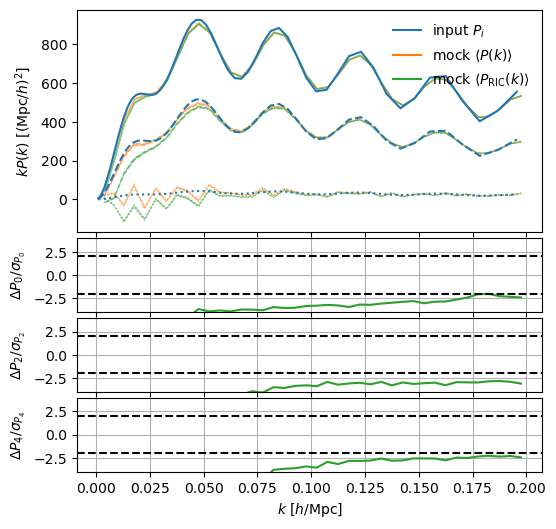

In [4]:
k, edges = pks[0].x(projs=0), pks[0].edges(projs=0)
pk_mean, pk_std = np.mean([np.array(pk.value).real for pk in pks], axis=0), np.std([np.array(pk.value).real for pk in pks], axis=0) / npk**0.5
pk_ic_mean, pk_ic_std = np.mean([np.array(pk.value).real for pk in pks_ic], axis=0), np.std([np.array(pk.value).real for pk in pks_ic], axis=0) / npk**0.5

height_ratios = [max(len(ells), 3)] + [1] * len(ells)
figsize = (6, 1. * sum(height_ratios))
fig, lax = plt.subplots(len(height_ratios), sharex=True, sharey=False, gridspec_kw={'height_ratios': height_ratios}, figsize=figsize, squeeze=True)
fig.subplots_adjust(hspace=0.05)
ax = lax[0]
maskin = kin < edges[-1]
linestyles = ['-', '--', ':']
colors = ['C0', 'C1', 'C2']
labels = ['input $P_i$', r'mock $\langle P(k) \rangle$', r'mock $\langle P_\mathrm{RIC}(k) \rangle$']
for color, label in zip(colors, labels):
    ax.plot([], [], color=color, linestyle='-', label=label)
for ill, ell in enumerate(ells):
    linestyle = linestyles[ill]
    ax.plot(kin[maskin], kin[maskin] * poles[ill][maskin], linestyle=linestyle, color=colors[0])
    kw = dict(lw=1., alpha=0.5)
    ax.fill_between(k, k * (pk_mean - pk_std)[ill], k * (pk_mean + pk_std)[ill], linestyle=linestyle, color=colors[1], **kw)
    ax.fill_between(k, k * (pk_ic_mean - pk_ic_std)[ill], k * (pk_ic_mean + pk_ic_std)[ill], linestyle=linestyle, color=colors[2], **kw)
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
for ill, ell in enumerate(ells):
    ax = lax[ill + 1]
    ax.plot(k, (pk_ic_mean[ill] - pk_mean[ill]) / pk_ic_std[ill], color=colors[2])
    ax.set_ylim(-3., 3.)
    ax.set_ylim(-4, 4)
    for offset in [-2., 2.]: ax.axhline(offset, color='k', linestyle='--')
    ax.grid(True)
    ax.set_ylabel(r'$\Delta P_{{{0:d}}} / \sigma_{{ P_{{{0:d}}} }}$'.format(ell))
lax[-1].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
utils.savefig(plots_dir / 'mocks_ric.png')
plt.show()

We clearly see the effect of the RIC on large scales, but not only.
Power spectrum measurements with and without RIC (= control variate) are very correlated at least at high $k$, so it is probably worth estimating the window matrix for this difference, and add the exact window matrix calculation for the control variate.

We have to compute the window matrix by slabs to avoid blowing up the memory. We implement reverse mode and forward mode. Reverse mode is slightly faster for mocks. Forward is faster for the exact calculation.

In [5]:
def get_wmat_slab_rev(func, nk, nells, poles, npk=10, nkslab=2, nellslab=3, **kwargs):
    # Reverse mode
    run_mocks = npk is not None
    if not run_mocks: npk = 1
    wmats = [np.zeros((nells, nk) + poles.shape) for i in range(npk)]
    nsplits = nk // nkslab
    ksplits = [slice(ik * nk // nsplits, (ik + 1) * nk // nsplits) for ik in range(nsplits)]
    nsplits = nells // nellslab
    ellsplits = [slice(ill * nells // nsplits, (ill + 1) * nells // nsplits) for ill in range(nsplits)]

    from tqdm import tqdm
    for ik in tqdm(ksplits):
        for ill in ellsplits:
            get_wmat = lambda pkin, **kwargs: jax.jacrev(lambda pkin: func(pkin, **kwargs)[ill, ik])(pkin)
            if run_mocks: get_wmat = jax.jit(get_wmat)
            get_wmat = jax.jit(get_wmat)
            kw = dict(kwargs)
            for imock in range(npk):
                if run_mocks: kw.update(seed=random.key(2 * imock + 3))
                wmats[imock][ill, ik] = get_wmat(poles, **kw)
    if run_mocks:
        return wmats
    return wmats[0]

def get_wmat_slab_fwd(func, poles, npk=10, nkslab=1, nellslab=3, **kwargs):
    # Forward mode
    nells, nk = poles.shape
    run_mocks = npk is not None
    if not run_mocks: npk = 1
    wmats = [None for i in range(npk)]
    nsplits = nk // nkslab
    ksplits = [np.arange(ik * nk // nsplits, (ik + 1) * nk // nsplits) for ik in range(nsplits)]
    nsplits = nells // nellslab
    ellsplits = [np.arange(ill * nells // nsplits, (ill + 1) * nells // nsplits) for ill in range(nsplits)]

    get_wmat = lambda s, **kwargs: jax.vmap(lambda s: jax.jvp(lambda poles: func(poles, **kwargs), (poles,), (s,))[1])(s)
    get_wmat = jax.jit(get_wmat)
    #get_wmat = lambda s, **kwargs: jax.jvp(lambda poles: func(poles, **kwargs), (poles,), (s,))[1]
    zeros = jnp.zeros_like(poles)
    from tqdm import tqdm
    for ik in tqdm(ksplits):
        for ill in ellsplits:
            #get_wmat = lambda pkin, **kwargs: jax.jacfwd(lambda pkin: func(poles.at[ill, ik].set(pkin), **kwargs))(pkin)
            #if run_mocks: get_wmat = jax.jit(get_wmat)
            args = (jnp.array([zeros.at[iill, iik].set(1.) for iill in ill for iik in ik]),)
            kw = dict(kwargs)
            for imock in range(npk):
                if run_mocks: kw.update(seed=random.key(2 * imock + 3))
                tmp = jnp.moveaxis(get_wmat(*args, **kw), 0, -1)
                tmp = tmp.reshape(tmp.shape[:2] + (len(ill), len(ik)))
                if wmats[imock] is None:
                    wmats[imock] = np.zeros(tmp.shape[:2] + poles.shape)
                wmats[imock][..., slice(ill[0], ill[-1] + 1), slice(ik[0], ik[-1] + 1)] = tmp
    if run_mocks:
        return wmats
    return wmats[0]

Let's first estimate the window matrix with the brute-force approach.

In [7]:
get_pk = lambda pkin, **kwargs: jnp.array(mock_survey(pkin, selection, ic='radial', unitary_amplitude=True, **kwargs).value).real
wmats_brute = get_wmat_slab_rev(get_pk, len(k), len(ells), poles, npk=25)
#wmats_brute = get_wmat_slab_fwd(get_pk, poles, npk=50)

100%|██████████| 20/20 [01:58<00:00,  5.93s/it]


Then with the control variate method.

In [8]:
def mock_survey_diff(poles, selection, unitary_amplitude=True, los='local', seed=random.key(42)):
    # Generate Gaussian field
    mesh = generate_anisotropic_gaussian_mesh(make_callable(poles), unitary_amplitude=unitary_amplitude,
                                              boxsize=selection.boxsize, meshsize=selection.meshsize, boxcenter=selection.boxcenter,
                                              los=los, seed=seed)

    # Multiply Gaussian field with survey selection function, then compute power spectrum
    norm = compute_normalization(selection, selection)
    powers = [compute_mesh_power(apply_selection(mesh, selection, ic=ic), edges=edges, ells=ells,
                                 los={'local': 'firstpoint'}.get(los, los)).clone(norm=norm) for ic in ['radial', None]]
    diff = jnp.array(powers[0].power_nonorm) - jnp.array(powers[1].power_nonorm)
    return diff.real / powers[0].norm


get_pk_diff = lambda pkin, **kwargs: mock_survey_diff(pkin, selection, unitary_amplitude=False, **kwargs)
wmats_diff = get_wmat_slab_rev(get_pk_diff, len(k), len(ells), poles, npk=25)

100%|██████████| 20/20 [02:32<00:00,  7.63s/it]


In [9]:
def mean_survey(poles, selection, los='local'):
    # Multiply Gaussian field with survey selection function, then compute power spectrum
    norm = compute_normalization(selection, selection)
    poles = make_callable(poles)
    if los == 'local': poles = (poles, los)  # local line-of-sight
    return compute_mean_mesh_power(selection, theory=poles, edges=edges, ells=ells, los={'local': 'firstpoint'}.get(los, los)).clone(norm=norm)

pk_mean = mean_survey(poles, selection)

In [10]:
get_pk_mean = lambda pkin, **kwargs: jnp.array(mean_survey(pkin, selection, **kwargs).value).real
#wmat_mean = get_wmat_slab_rev(get_pk_mean, len(k), len(ells), poles, npk=None)
# In this case fwd is more efficient, maybe because the pipeline is deeper
wmat_mean = get_wmat_slab_fwd(get_pk_mean, poles, npk=None)

100%|██████████| 200/200 [01:36<00:00,  2.08it/s]


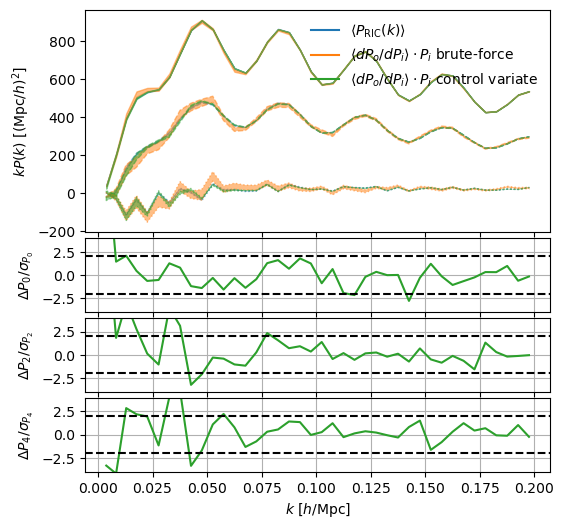

In [11]:
pkts_cv = [jnp.tensordot(wmat_mean + wmat_diff, poles, axes=((2, 3), (0, 1))) for wmat_diff in wmats_diff]
pkt_cv_mean, pkt_cv_std = np.mean(pkts_cv, axis=0), np.std(pkts_cv, axis=0) / len(pkts_cv)**0.5

pkts_brute = [jnp.tensordot(wmat, poles, axes=((2, 3), (0, 1))) for wmat in wmats_brute]
pkt_brute_mean, pkt_brute_std = np.mean(pkts_brute, axis=0), np.std(pkts_brute, axis=0) / len(pkts_brute)**0.5

height_ratios = [max(len(ells), 3)] + [1] * len(ells)
figsize = (6, 1. * sum(height_ratios))
fig, lax = plt.subplots(len(height_ratios), sharex=True, sharey=False, gridspec_kw={'height_ratios': height_ratios}, figsize=figsize, squeeze=True)
fig.subplots_adjust(hspace=0.05)
ax = lax[0]
maskin = kin < edges[-1]
linestyles = ['-', '--', ':']
colors = ['C0', 'C1', 'C2']
labels = [r'$\langle P_\mathrm{RIC}(k) \rangle$',
          r'$\langle dP_o/dP_i \rangle \cdot P_i$ brute-force',
          r'$\langle dP_o/dP_i \rangle \cdot P_i$ control variate']
for color, label in zip(colors, labels):
    ax.plot([], [], color=color, linestyle='-', label=label)
for ill, ell in enumerate(ells):
    linestyle = linestyles[ill]
    kw = dict(lw=1., alpha=0.5)
    ax.fill_between(k, k * (pk_ic_mean - pk_ic_std)[ill], k * (pk_ic_mean + pk_ic_std)[ill], linestyle=linestyle, color=colors[0], **kw)
    ax.fill_between(k, k * (pkt_brute_mean - pkt_brute_std)[ill], k * (pkt_brute_mean + pkt_brute_std)[ill], linestyle=linestyle, color=colors[1], **kw)
    ax.fill_between(k, k * (pkt_cv_mean - pkt_cv_std)[ill], k * (pkt_cv_mean + pkt_cv_std)[ill], linestyle=linestyle, color=colors[2], **kw)
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
factor = 1.
for ill, ell in enumerate(ells):
    ax = lax[ill + 1]
    #ax.plot(k, (pk_ic_mean[ill] - pkt_brute_mean[ill]) / pk_ic_std[ill] * factor, color=colors[1])
    ax.plot(k, (pk_ic_mean[ill] - pkt_cv_mean[ill]) / pk_ic_std[ill] * factor, color=colors[2])
    ax.set_ylim(-3., 3.)
    ax.set_ylim(-4, 4)
    for offset in [-2., 2.]: ax.axhline(offset, color='k', linestyle='--')
    ax.grid(True)
    ax.set_ylabel(r'$\Delta P_{{{0:d}}} / \sigma_{{ P_{{{0:d}}} }}$'.format(ell))
lax[-1].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
utils.savefig(plots_dir / 'mocks_ric_wmatrix.png')
plt.show()

It is nice to see that the control variate works well (green area smaller than orange). With just 25 mocks we are able to reach the precision of 1000 mock realizations for most observed $k$'s. We could probably increase the number of mocks just for observed low-$k$ bins.